# Uniaxial Tension - Elasticity, Physics Informed Neural Network

Thomas Allard and Samantha Walker

In [38]:
#Imports
import numpy as np 
import sciann as sn 
import matplotlib.pyplot as plt
import scipy.io
import netCDF4
import xarray as xr

import os

In [39]:
# Specify parameters and things
mode = 'train'   # 'test' to load PINN weights from previously trained model
                # 'train' to train a new model

#trained_file = 'trained-navier-stokes.hdf5'
data_file = '../abaqus/final_elastic/elastic_cdf.nc'

In [40]:
# load in data_file as xarray DataSet
set = xr.open_dataset(data_file)

In [136]:
# Load in displacements and create an ndarray
disp_x=set.sel(field='ux').to_array()
disp_y=set.sel(field='uy').to_array()
disps=np.dstack([disp_x,disp_y])
print(np.shape(disps))
# Num = np.shape(disps)[1] # 2760
# Var_Num = np.shape(disps)[2] # 2

(81, 2760, 2)


In [54]:
# Load in grid
def file2array(file):
    # load in each line of data as array
    with open(file, 'r') as f:
        line_string = f.read().splitlines()
    
    # loop through the lines from the file, split, and append to list
    list = []
    timestamp = 0 # default 
    for i, line in enumerate(line_string):
        list.append(line.split())

    # convert list to an array of type float64
    array = np.asarray(list, dtype=np.float64)

    return(array)
node_file = '../abaqus/final_elastic/nodes.txt'
nodal_coordinates = file2array(node_file)
grid = nodal_coordinates[:,1:3]
print(grid)
print(np.shape(grid))

[[    0.        -1500.       ]
 [   66.6666641 -1500.       ]
 [  133.333328  -1500.       ]
 ...
 [ 2866.66675    1500.       ]
 [ 2933.33325    1500.       ]
 [ 3000.         1500.       ]]
(2760, 2)


In [43]:
# Extract time and put in an array
time = [] # will be shape (81,)
for DataArray in set.values():
    time.append(DataArray.attrs['time'])

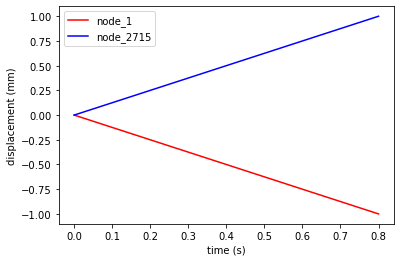

In [44]:
# Check that data loaded in correctly by plotting disp_y for node 1 (bottom left) and node 2715 (top left)
plt.plot(time,set.sel(field='uy',node='1').to_array(),   color='red',label='node_1')
plt.plot(time,set.sel(field='uy',node='2715').to_array(),color='blue',label='node_2715')
plt.xlabel('time (s)')
plt.ylabel('displacement (mm)')
plt.legend()
plt.show()

In [46]:
#disp_x=set.sel(field='ux').to_array()
print(np.shape(disp_x)) # (81, 2760)
P_star = set.sel(field='S22').to_array() #(81, 2760)
print(np.shape(P_star))
print(P_star)

(81, 2760)
(81, 2760)
<xarray.DataArray (variable: 81, node: 2760)>
array([[  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  1.92306888,   1.92306888,   1.92306888, ...,   1.92306888,
          1.92306888,   1.92306888],
       [  3.84612179,   3.84612179,   3.84612179, ...,   3.84612179,
          3.84612179,   3.84612179],
       ...,
       [149.95127869, 149.95127869, 149.95127869, ..., 149.95127869,
        149.95127869, 149.95127869],
       [151.87309265, 151.87309265, 151.87309265, ..., 151.87309265,
        151.87309265, 151.87309265],
       [153.79489136, 153.79489136, 153.79489136, ..., 153.79489136,
        153.79489136, 153.79489136]])
Coordinates:
  * node      (node) object '1' '2' '3' '4' '5' ... '2757' '2758' '2759' '2760'
    field     <U3 'S22'
  * variable  (variable) <U8 'step_000' 'step_001' ... 'step_079' 'step_080'


In [132]:
np.shape(grid)

(2760, 2)

In [185]:
# define function for subsampling data
def PrepareData(data, grid, time, random=True): # num_data, data_file
    
    # Load data
    #data = scipy.io.loadmat('/content/' + data_file)
    #data = scipy.io.loadmat(data_file)
    
    # will want to change these to correspond to our input variables
    #U_star = data['U_star'] # N x 2 x T
    ## displacements -> U_star
    disp_x=set.sel(field='ux').to_array() # T x N # (81, 2760)
    disp_y=set.sel(field='uy').to_array() # T x N # (81, 2760)
    U_star=np.dstack([disp_x,disp_y])     # T x N x 2 (81, 2760, 2)
    
    # time
    time = [] # will be shape (81,)
    for DataArray in set.values():
        time.append(DataArray.attrs['time'])
    
    # Solution S22 -> P_star
    P_star = np.asarray(set.sel(field='S22').to_array()) # T x N
    print(np.shape(P_star))
    
    # time -> t_star
    t_star = time #data['t'] # T x 1 # (81,)
    
    # grid -> X_star
    X_star = grid # grid is N x 2 or shape (2760, 2)
    
    N = np.shape(X_star)[0] #X_star.shape[0]
    T = np.shape(t_star)[0] #t_star.shape[0]
    
    # Rearrange Data 
    XX = np.tile(X_star[:,0:1], (1,T)) # N x T # (2760, 81)
    YY = np.tile(X_star[:,1:2], (1,T)) # N x T # (2760, 81)
    TT = np.tile(t_star, (1,N)).T # NT x 1 # (223560, 1)
    
    UU = U_star[:,:,0].T # N x T
    VV = U_star[:,:,1].T # N x T
    PP = P_star.T # N x T
    print(np.shape(PP)) # N x T
    
    # Pick random data.
    if random:
        idx = np.random.choice(N*T, N, replace=False) # num_data
    else:
        idx = np.arange(0, N*T)
    
    x = XX
    y = YY
    t = t_star
    
    x = XX.flatten()[idx,None] # NT x 1
    y = YY.flatten()[idx,None] # NT x 1
    t = TT.flatten()[idx,None] # NT x 1
    
    u = UU # T x N # (81, 2760)
    v = VV # T x N # (81, 2760)
    p = PP # T x N # (81, 2760)
    
    u = UU.flatten()[idx,None] # NT x 1
    v = VV.flatten()[idx,None] # NT x 1
    p = PP.flatten()[idx,None] # NT x 1
 
    return (x,y,t,u,v,p)


In [188]:
x,y,t,u,v,p = PrepareData(set, grid, time, random=True)
# print(data_prep)
#print(disp_x.shape) # [:,2759]
#print(t.shape) # [:,80]
print(np.shape(x))
print(np.shape(y))
print(np.shape(t))
print(np.shape(u))
print(np.shape(v))
print(np.shape(p))

(81, 2760)
(2760, 81)
(2760, 1)
(2760, 1)
(2760, 1)
(2760, 1)
(2760, 1)
(2760, 1)


In [9]:
# Setting up cost function
layers = 8
neurons = 20

x = sn.Variable("x", dtype='float64')
y = sn.Variable("y", dtype='float64')
t = sn.Variable("t", dtype='float64')

P = sn.Functional("P", [x, y, t], layers*[neurons], 'tanh') # HMMMMM?
Psi = sn.Functional("Psi", [x, y, t], layers*[neurons], 'tanh') # HMMMMM?

'''
Abaqus takes E and nu
The Navier form of equations takes mu and lambda

E = [mu*(3*lambda + 2*mu)] / [lambda + mu]
nu = lambda / [2*(lambda + mu)]

mu = E / [2*(1 + nu)]
lambda = [nu*E] / [(1 + nu)*(1 - 2*nu)]

Inputs values:
E  = 210 GPa
nu = 0.3

Expected values:
mu     =  63.636363 GPa
lambda = 121.154385 GPa
'''

mu = sn.Parameter(np.random.rand(), inputs=[x,y,t], name="mu")
lamb = sn.Parameter(np.random.rand(), inputs=[x,y,t], name="lambda")

# partials
u_t = sn.diff(u, t)
u_x = sn.diff(u, x)
u_y = sn.diff(u, y)
u_tt = sn.diff(u, t, order=2)
u_xx = sn.diff(u, x, order=2)
u_yy = sn.diff(u, y, order=2)
u_xy = sn.diff(u_x, y)

v_t = sn.diff(v, t)
v_x = sn.diff(v, x)
v_y = sn.diff(v, y)
v_tt = sn.diff(v, t, order=2)
v_xx = sn.diff(v, x, order=2)
v_yy = sn.diff(v, y, order=2)
v_xy = sn.diff(v_x, y)

# define constraints
d1 = sn.Data(u)
d2 = sn.Data(v)
d3 = sn.Data(P) # HMMMMM?



NameError: name 'u' is not defined